In [47]:
import jax
import netket as nk
import numpy as np
from netket.operator.spin import sigmax,sigmaz, sigmap, sigmam
import time
from scipy.sparse.linalg import eigsh
import jax.numpy as jnp
import matplotlib.pyplot as plt
def ABC(L):
    B = {}
    A = {0}
    C = {}
    for i in range (1, L):
        B[i] = [i+j*(L-1) for j in range(i+1)]
    for i in range (L, 2*L-2):
        B[i] = [(i-L+1)*L+j*(L-1) for j in range(1, 2*L-i)]
    for i in B:
        if i!=1:
            B[i]+=B[i-1]
            B[i].sort()
    for i in B:
        C[i] = set(range(L**2))-set(B[i])-A
    return A, B, C

def ABC_complete(L, pos_A):
    B = {}
    A = {pos_A}
    C = {}
    y0 = tuple(A)[0]//L
    x0 = tuple(A)[0]%L

    for y in range (L):
        for x in range (L):
            if y*L+x> tuple(A)[0]:
                d = np.abs(y-y0)+np.abs(x-x0)
                if d not in B:
                    B[d] = [y*L+x]
                else:
                    B[d].append(y*L+x)
    B = dict(sorted(B.items()))
    C = dict(sorted(C.items()))
    for i in B:
        if i!=1:
            B[i] += B[i-1]
        B[i].sort()
    B.popitem()     #remove the last element
    for i in B:
        C[i] = set(range(tuple(A)[0]+1, L**2))-set(B[i])
    B = dict(sorted(B.items()))
    C = dict(sorted(C.items()))
    return A,B,C

def cmi_(prob_exact, L):  #cmi for the first spin as |A|
    A,B,C = ABC(L)
    cmi = []
    p_ab = prob_exact.sum(axis=tuple(set(range(L**2))-A))+1e-30
    p_bc = prob_exact.sum(axis=tuple(A))+1e-30
    cmi.append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(prob_exact*np.log(prob_exact+1e-30)))
    for i in B:
        tmp = 0
        p_ab = prob_exact.sum(axis=tuple(C[i]))
        tmp += np.sum(p_ab*np.log(p_ab))+1e-30
        p_bc = prob_exact.sum(axis=tuple(A))
        tmp += np.sum(p_bc*np.log(p_bc))+1e-30
        tmp -= np.sum(prob_exact*np.log(prob_exact+1e-30))
        p_b = prob_exact.sum(axis=tuple(C[i].union(A)))+1e-30
        tmp -= np.sum(p_b*np.log(p_b))
        cmi.append(-tmp)
    return np.array(cmi)

def cmi_traceout(prob_exact, L):
    cmi = [[] for i in range(L*(L-2))]
    for i in range (L*(L-2)):
        A,B,C = ABC_complete(L, i)
        p_ab = prob_exact.sum(axis=tuple(set(range(L**2))-A))+1e-30
        p_bc = prob_exact.sum(axis=tuple(set(range(i)).union(A)))+1e-30
        p_abc = prob_exact.sum(axis=tuple(set(range(i))))+1e-30
        cmi[i].append(-np.sum(p_ab*np.log(p_ab))-np.sum(p_bc*np.log(p_bc))+np.sum(p_abc*np.log(p_abc)))
        for j in B:
            tmp = 0
            p_ab = prob_exact.sum(axis=tuple(set(range(i)).union(C[j])))
            tmp += np.sum(p_ab*np.log(p_ab))+1e-30
            p_bc = prob_exact.sum(axis=tuple(set(range(i)).union(A)))
            tmp += np.sum(p_bc*np.log(p_bc))+1e-30
            tmp -= np.sum(p_abc*np.log(p_abc))
            p_b = prob_exact.sum(axis=tuple(set(range(i)).union(C[j].union(A))))+1e-30
            tmp -= np.sum(p_b*np.log(p_b))
            cmi[i].append(-tmp)

    return cmi

def correlation_all(prob_exact, L): #correlation for all spin and then taking average
    corr = [[] for i in range(2*(L-1)+1)]
    mean_corr = [[] for i in range(2*(L-1)+1)]
    var_corr = [[] for i in range(2*(L-1)+1)]
    for i in range(L**2):
        for j in range(i+1, L**2):
            y0 = i//L
            x0 = i%L
            y1 = j//L
            x1 = j%L
            p_spin = prob_exact.sum(axis=tuple(set(range(L**2))-set([i, j])))+1e-30
            p_spin0 = p_spin.sum(axis=0)
            p_spin1 = p_spin.sum(axis=1)
            cor = (p_spin[0, 0]+p_spin[1, 1]-p_spin[0, 1]-p_spin[1, 0])-(p_spin0[0]-p_spin0[1])*(p_spin1[0]-p_spin1[1])
            corr[np.abs(y1-y0)+np.abs(x1-x0)].append(cor)
        p_spin = prob_exact.sum(axis=tuple(set(range(L**2))-set([i])))+1e-30
        cor = (p_spin**2).sum()-(p_spin[0]-p_spin[1])**2
        corr[0].append(cor)
    for i in range(len(corr)):
        mean_corr[i] = np.array(corr[i]).mean()
        var_corr[i] = np.array(corr[i]).var()
    return np.array(mean_corr), np.array(var_corr)

def correlation_one(prob_exact, L): #correlation for one spin at [0, 0]
    corr = [[] for i in range(2*(L-1)+1)]
    mean_corr = [[] for i in range(2*(L-1)+1)]
    var_corr = [[] for i in range(2*(L-1)+1)]
    for i in range(1, L**2):
        y0 = 0
        x0 = 0
        y1 = i//L
        x1 = i%L
        p_spin = prob_exact.sum(axis=tuple(set(range(L**2))-set([0, i])))+1e-30
        p_spin0 = p_spin.sum(axis=0)
        p_spin1 = p_spin.sum(axis=1)
        cor = (p_spin[0, 0]+p_spin[1, 1]-p_spin[0, 1]-p_spin[1, 0])-(p_spin0[0]-p_spin0[1])*(p_spin1[0]-p_spin1[1])
        corr[np.abs(y1-y0)+np.abs(x1-x0)].append(cor)
    p_spin = prob_exact.sum(axis=tuple(set(range(L**2))-set([0])))+1e-30
    cor = (p_spin**2).sum()-(p_spin[0]-p_spin[1])**2
    corr[0].append(cor)
    for i in range(len(corr)):
        mean_corr[i] = np.array(corr[i]).mean()
        var_corr[i] = np.array(corr[i]).var()
    return np.array(mean_corr), np.array(var_corr)
L = 4
N = L*L
periodic = False
hi = nk.hilbert.Spin(s=1 / 2, N =  N)
J1 = 1.0
J2_ = [0., 0.2, 0.4, 0.6, 0.8, 1.0]


for J2 in J2_ :
    H = J1*sum([2*(sigmap(hi, y*L+x)*sigmam(hi, (y+1)*L+x)+sigmam(hi, y*L+x)*sigmap(hi, (y+1)*L+x))+sigmaz(hi, y*L+x)*sigmaz(hi, (y+1)*L+x) for y in range(L-1) for x in range(L)])  #up-down J1
    H += J1*sum([2*(sigmap(hi, y*L+x)*sigmam(hi, y*L+x+1)+sigmam(hi, y*L+x)*sigmap(hi, y*L+x+1))+sigmaz(hi, y*L+x)*sigmaz(hi, y*L+x+1) for y in range(L) for x in range(L-1)]) #left-right J1
    H += J2*sum([2*(sigmap(hi, y*L+x)*sigmam(hi, (y+1)*L+x+1)+sigmam(hi, y*L+x)*sigmap(hi, (y+1)*L+x+1))+sigmaz(hi, y*L+x)*sigmaz(hi, (y+1)*L+x+1) for y in range(L-1) for x in range(L-1)])  #right-down J2
    H += J2*sum([2*(sigmap(hi, y*L+x+1)*sigmam(hi, (y+1)*L+x)+sigmam(hi, y*L+x+1)*sigmap(hi, (y+1)*L+x))+sigmaz(hi, y*L+x+1)*sigmaz(hi, (y+1)*L+x) for y in range(L-1) for x in range(L-1)])  #left-down J2

    if (periodic == True):
    #periodic boundary conditions
        H+= J1*sum([2*(sigmap(hi, x)*sigmam(hi, (L-1)*L+x)+sigmam(hi, x)*sigmap(hi, (L-1)*L+x))+sigmaz(hi, x)*sigmaz(hi, (L-1)*L+x) for x in range(L)]) # last row - first row J1
        H+= J1*sum([2*(sigmap(hi, y*L)*sigmam(hi, y*L+L-1)+sigmam(hi, y*L)*sigmap(hi, y*L+L-1))+sigmaz(hi, y*L)*sigmaz(hi, y*L+L-1) for y in range(L)]) # last column - first column J1
        H+= J2*sum([2*(sigmap(hi, y*L+L-1)*sigmam(hi, (y+1)*L)+sigmam(hi, y*L+L-1)*sigmap(hi, (y+1)*L))+sigmaz(hi, y*L+L-1)*sigmaz(hi, (y+1)*L) for y in range(L-1)]) # last column - first column J2 (right down)
        H+= J2*sum([2*(sigmap(hi, y*L)*sigmam(hi, (y+2)*L-1)+sigmam(hi, y*L)*sigmap(hi, (y+2)*L-1))+sigmaz(hi, y*L)*sigmaz(hi, (y+2)*L-1) for y in range(L-1)]) #  last column - first column J2 (left down)
        H+= J2*sum([2*(sigmap(hi, x+1)*sigmam(hi, (L-1)*L+x)+sigmam(hi, x+1)*sigmap(hi, (L-1)*L+x))+sigmaz(hi, x+1)*sigmaz(hi, (L-1)*L+x) for x in range(L-1)]) # last row - first row J2 (right down)
        H+= J2*sum([2*(sigmap(hi, x)*sigmam(hi, (L-1)*L+x+1)+sigmam(hi, x)*sigmap(hi, (L-1)*L+x+1))+sigmaz(hi, x)*sigmaz(hi, (L-1)*L+x+1) for x in range(L-1)]) # last row - first row J2 (left down)
        H+= J2*(2*(sigmap(hi, L*L-1)*sigmam(hi, 0)+sigmam(hi, L*L-1)*sigmap(hi, 0))+sigmaz(hi, L*L-1)*sigmaz(hi, 0)) # right down corner J2
        H+= J2*(2*(sigmap(hi, L*(L-1))*sigmam(hi, L-1)+sigmam(hi, L*(L-1))*sigmap(hi, L-1))+sigmaz(hi, L*(L-1))*sigmaz(hi, L-1)) # left down corner J2
    sp_h = H.to_sparse()
    eig_vals, eig_vecs = eigsh(sp_h, k=3, which="SA")
    print("eigenvalues with scipy sparse J2="+str(J2) +":", eig_vals)
    prob_exact = eig_vecs[:,0]**2
    shape = (2,) * (L**2)
    prob_exact = prob_exact.reshape(*shape)
    mean_corr, var_corr = correlation_all(prob_exact, L)
    cmi = cmi_(prob_exact, L)
    cmi_all = cmi_traceout(prob_exact, L)
    np.save("result/2DJ1J2/cmi_2DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", np.array(cmi))
    np.save("result/2DJ1J2/gap_2DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", np.array(eig_vals[1]-eig_vals[0]))
    np.save("result/2DJ1J2/mean_corr_2DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", np.array(mean_corr))
    np.save("result/2DJ1J2/var_corr_2DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", np.array(var_corr))
    np.save("result/2DJ1J2/cmi_all_2DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", np.array(cmi_all))

eigenvalues with scipy sparse J2=0.0: [-36.75682826 -34.74774992 -34.74774992]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16484\1619700830.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save("result/2DJ1J2/cmi_all_2DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", np.array(cmi_all))


eigenvalues with scipy sparse J2=0.2: [-33.88595249 -31.79003146 -31.79003146]
eigenvalues with scipy sparse J2=0.4: [-31.23016129 -29.04438823 -29.04438823]
eigenvalues with scipy sparse J2=0.6: [-28.93365371 -27.31110731 -26.82997479]
eigenvalues with scipy sparse J2=0.8: [-28.56645793 -27.25407585 -27.16241403]
eigenvalues with scipy sparse J2=1.0: [-32.09056216 -31.29282251 -30.97714647]


In [52]:
import numpy as np
import matplotlib.pyplot as plt
# Dictionary to store the loaded arrays
L = 4
N = L*L
periodic = False

cmi = {}
mean_corr= {}
var_corr = {}
gap = {}
cmi_traceout = {}
# Looping through the values and loading each file
for J2 in J2_:
    filename = f"result/2DJ1J2/cmi_2DJ1J2_L{L}_J2_{J2}periodic_{periodic}.npy"
    cmi[J2] = np.load(filename)
    filename = f"result/2DJ1J2/mean_corr_2DJ1J2_L{L}_J2_{J2}periodic_{periodic}.npy"
    mean_corr[J2] = np.load(filename)
    filename = f"result/2DJ1J2/var_corr_2DJ1J2_L{L}_J2_{J2}periodic_{periodic}.npy"
    var_corr[J2] = np.load(filename)
    filename = f"result/2DJ1J2/gap_2DJ1J2_L{L}_J2_{J2}periodic_{periodic}.npy"
    gap[J2] = np.load(filename)
    filename = f"result/2DJ1J2/cmi_all_2DJ1J2_L{L}_J2_{J2}periodic_{periodic}.npy"
    cmi_traceout[J2] = np.load(filename, allow_pickle=True)



In [62]:
cmi_length = []
err_cmi_length =[]
corre_length = []
err_corre_length = []
cmi_length_traceout = [[] for i in range (len(J2_))]
err_cmi_length_traceout = [[] for i in range (len(J2_))]
for i in J2_:
    df = len(cmi[i])-2
    (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi[i])), -np.log(cmi[i]), 1, full=True)
    mean_x = np.mean(np.arange(len(cmi[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi[i])) - mean_x)**2))
    cmi_length.append(cmi_len)
    err_cmi_length.append(err)

    df = len(mean_corr[i])-2
    (corr_len, b2), residuals, _, _, _ = np.polyfit(np.arange(len(mean_corr[i])), -np.log(np.abs(mean_corr[i])), 1, full=True)
    mean_x = np.mean(np.arange(len(mean_corr[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(mean_corr[i])) - mean_x)**2))
    corre_length.append(corr_len)
    err_corre_length.append(err)

    for j in range(len(cmi_traceout[i])):
        df = len(cmi_traceout[i][j])-2
        (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi_traceout[i][j])), -np.log(cmi_traceout[i][j]), 1, full=True)
        mean_x = np.mean(np.arange(len(cmi_traceout[i][j])))
        err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi_traceout[i][j])) - mean_x)**2))
        cmi_length_traceout[J2_.index(i)].append(cmi_len)
        err_cmi_length_traceout[J2_.index(i)].append(err)




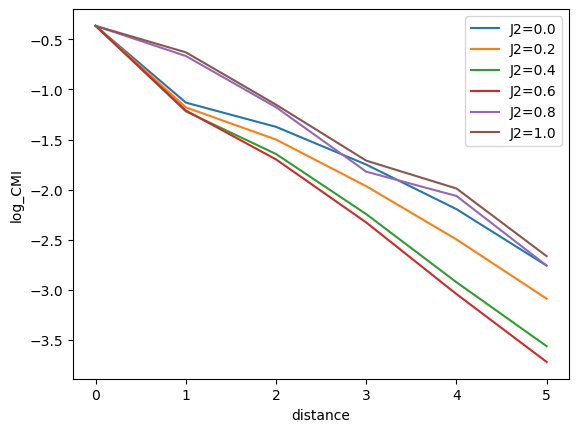

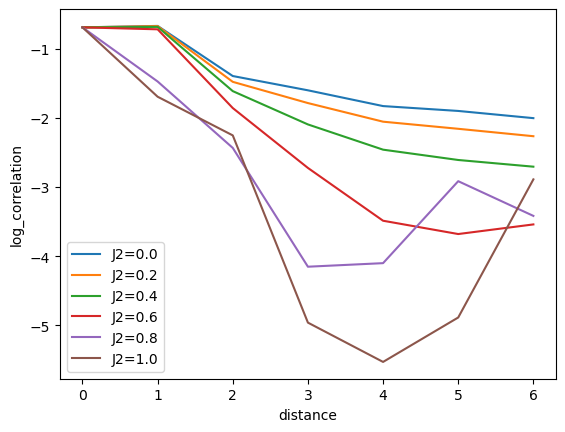

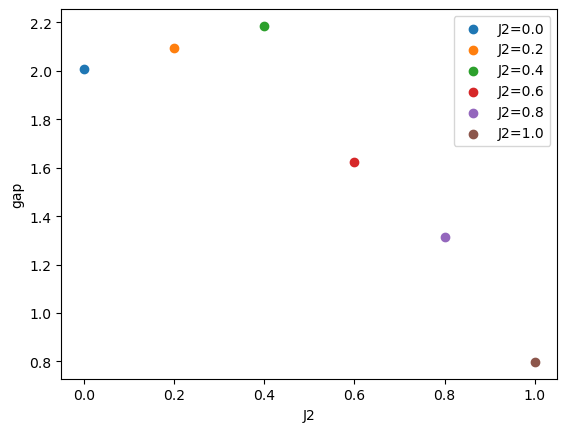

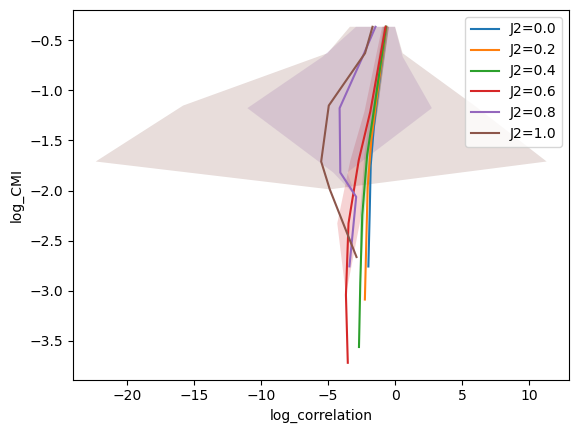

In [73]:
for i in J2_:
    plt.plot(np.log(cmi[i]), label="J2="+str(i))
plt.xlabel("distance")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/2DJ1J2/cmi_2DJ1J2_L"+str(L)+"_periodic_"+str(periodic)+".png")
plt.show()

for i in J2_:
    plt.plot(np.log(np.abs(mean_corr[i])), label="J2="+str(i))
    #plt.fill_between(np.arange(len(mean_corr[i])) ,np.log(np.abs(mean_corr[i])) - 1/mean_corr[i]*np.sqrt(var_corr[i]) , np.log(np.abs(mean_corr[i])) + 1/np.abs(mean_corr[i])*np.sqrt(var_corr[i]), alpha=0.2)
plt.xlabel("distance")
plt.ylabel("log_correlation")
plt.legend()
plt.savefig("figure/2DJ1J2/correlation_2DJ1J2_L"+str(L)+"_periodic_"+str(periodic)+".png")
plt.show()

for i in J2_:
    plt.scatter(i, gap[i], label="J2="+str(i))
plt.xlabel("J2")
plt.ylabel("gap")
plt.legend()
plt.savefig("figure/2DJ1J2/gap_2DJ1J2_L"+str(L)+"_periodic_"+str(periodic)+".png")
plt.show()

for i in J2_:
    plt.plot(np.log(np.abs(mean_corr[i][1:])), np.log(cmi[i]), label="J2="+str(i))
    plt.fill_betweenx(np.log(cmi[i]), np.log(np.abs(mean_corr[i][1:])) - 1/np.abs(mean_corr[i][1:])*np.sqrt(var_corr[i][1:]) , np.log(np.abs(mean_corr[i][1:])) + 1/np.abs(mean_corr[i][1:])*np.sqrt(var_corr[i][1:]), alpha=0.2)
plt.xlabel("log_correlation")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/2DJ1J2/correlation_cmi_2DJ1J2_L"+str(L)+"_periodic_"+str(periodic)+".png")
plt.show()


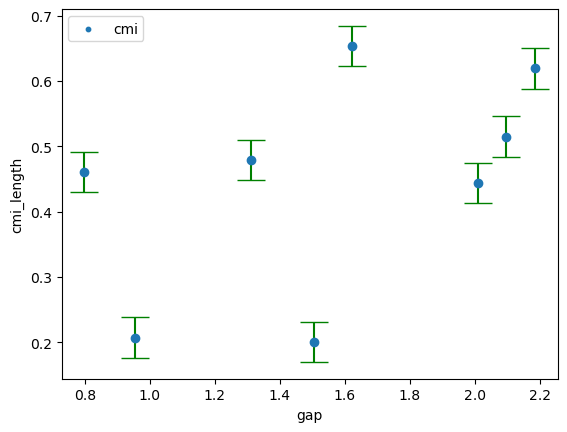

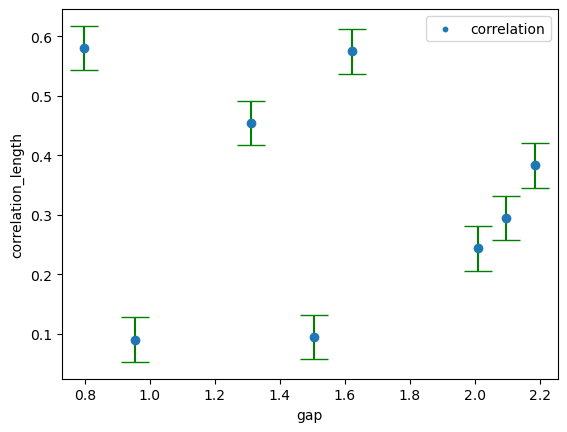

In [46]:
gap_list = []
for i in J2_:
    gap_list.append(gap[i])

plt.scatter(gap_list, cmi_length, label="cmi", s=10)
plt.errorbar(gap_list, cmi_length, yerr=err_cmi_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("cmi_length")
plt.legend()
plt.savefig("figure/2DJ1J2/cmi_length_gap_2DJ1J2_L"+str(L)+"_periodic_"+str(periodic)+".png")
plt.show()

plt.scatter(gap_list, corre_length, label="correlation", s=10)
plt.errorbar(gap_list, corre_length, yerr=err_corre_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("correlation_length")
plt.legend()
plt.savefig("figure/2DJ1J2/correlation_length_gap_2DJ1J2_L"+str(L)+"_periodic_"+str(periodic)+".png")
plt.show()


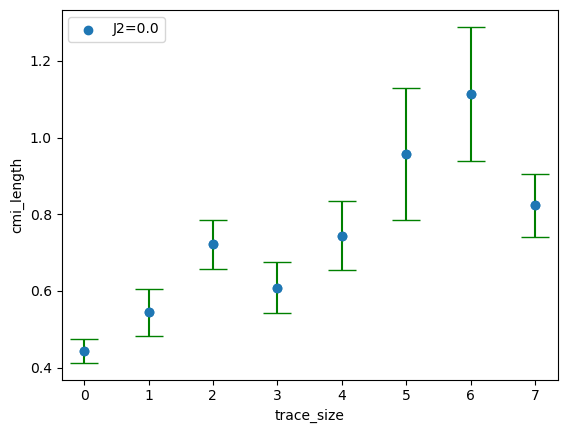

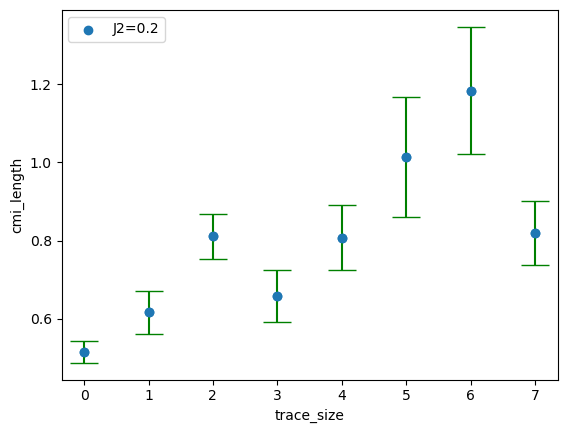

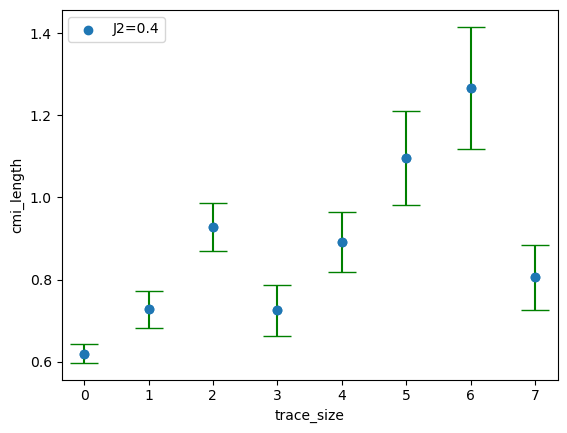

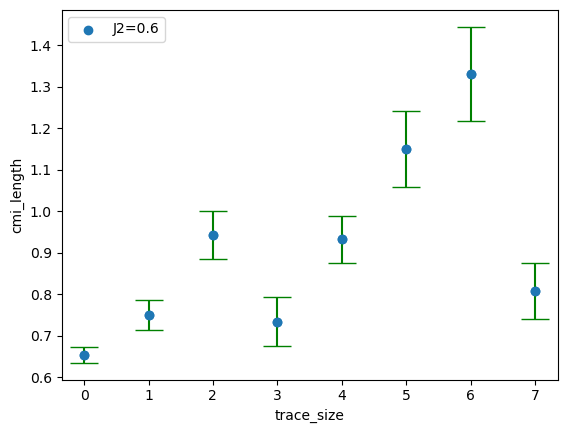

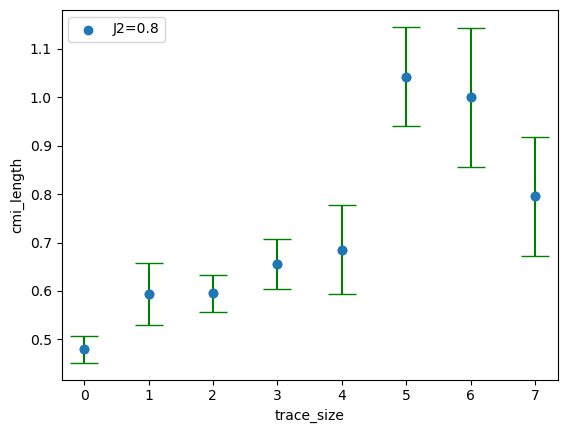

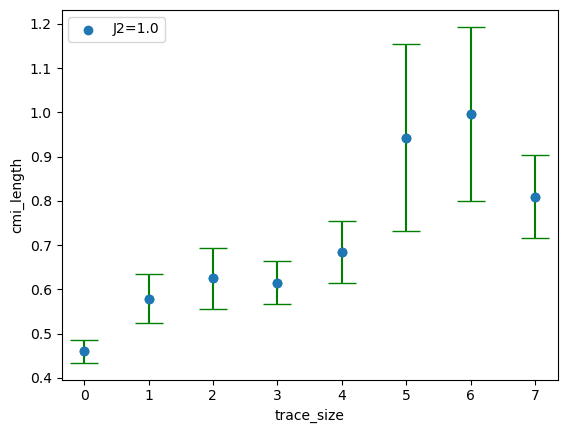

<Figure size 640x480 with 0 Axes>

In [66]:
for i in range(len(J2_)):
    plt.scatter(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], label = "J2="+str(J2_[i]))
    plt.errorbar(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], yerr=np.array(err_cmi_length_traceout[i]).ravel(), fmt='o', ecolor='g', capthick=1, capsize=10)
    plt.xlabel("trace_size")
    plt.ylabel("cmi_length")
    plt.legend()
    plt.savefig("figure/2DJ1J2/cmi_length_traceout_2DJ1J2_L"+str(L)+"_J2="+str(J2_[i])+"_periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()